1. Gerekli kütüphaneler

In [13]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import seaborn as sns

2. Veriyi okuma

In [14]:
# Verileri oku
train_df = pd.read_csv("../datasets/pca/train_mental_pca.csv")
test_df = pd.read_csv("../datasets/pca/test_mental_pca.csv")

# Özellik ve hedef ayır
X_train = train_df.drop("treatment", axis=1)
y_train = train_df["treatment"]

X_test = test_df.drop("treatment", axis=1)
y_test = test_df["treatment"]

# Kategorik hedefi one-hot formatına çevir
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

3. ANN modeli

In [15]:
# ANN mimarisi
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(2, activation='softmax')  # 2 sınıf için softmax
])

# Derleme
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 64)             │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,554 (13.88 KB)

 Trainable params: 3,554 (13.88 KB)

 Non-trainable params: 0 (0.00 B)

4. Model eğitimi

In [16]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_cat,
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6072 - loss: 0.7923 - val_accuracy: 0.7350 - val_loss: 0.4886
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7327 - loss: 0.5437 - val_accuracy: 0.7700 - val_loss: 0.4446
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7495 - loss: 0.5475 - val_accuracy: 0.7750 - val_loss: 0.4332
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7896 - loss: 0.4683 - val_accuracy: 0.7800 - val_loss: 0.4344
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7858 - loss: 0.4682 - val_accuracy: 0.7800 - val_loss: 0.4359
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7819 - loss: 0.4914 - val_accuracy: 0.7850 - val_loss: 0.4351
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7728 - loss: 0.4733 - val_accuracy: 0.7750 - val_loss: 0.4352
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7721 - loss: 0.4962 - val_accuracy: 0.7800 - v

5. Tahmin, rapor ve görselleştirme

In [17]:
# Tahmin (olasılıklar)
y_pred_proba = model.predict(X_test)

# En yüksek olasılığa göre sınıf tahmini
y_pred = y_pred_proba.argmax(axis=1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


📋 Sınıflandırma Raporu (ANN):

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       124
           1       0.81      0.81      0.81       127

    accuracy                           0.81       251
   macro avg       0.81      0.81      0.81       251
weighted avg       0.81      0.81      0.81       251



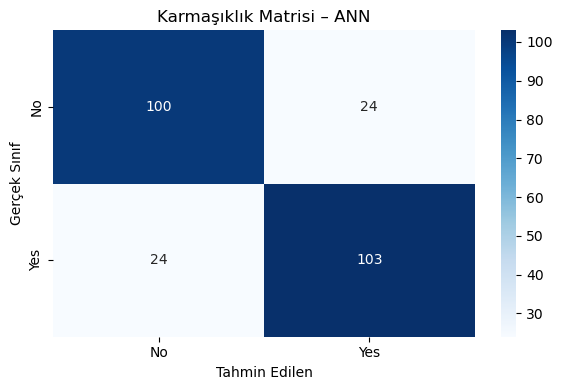

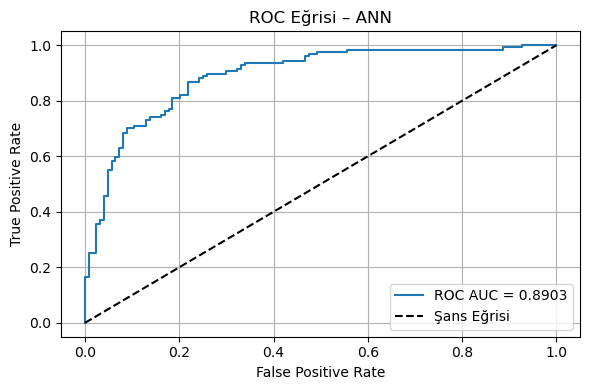

In [18]:
# Rapor
print("📋 Sınıflandırma Raporu (ANN):\n")
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.title("Karmaşıklık Matrisi – ANN")
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek Sınıf")
plt.tight_layout()
plt.show()

# Sadece pozitif sınıfın (1) olasılığı alınır
y_score = y_pred_proba[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Çizim
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], 'k--', label="Şans Eğrisi")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Eğrisi – ANN")
plt.legend(loc="lower right")
plt.grid()
plt.tight_layout()
plt.show()